[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nahuelalmeira/midnight/blob/main/notebooks/notebook.ipynb)

In [1]:
#!pip install --quiet git+https://github.com/nahuelalmeira/midnight

### General Config

Standard imports

In [2]:
# Graphics
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set()
sns.set_context("talk")
matplotlib.rcParams["figure.figsize"] = (12, 8)

Module imports

In [3]:
from midnight.player import Player
from midnight.game import Game
from midnight.strategy import (
    ConservativeStrategy,
    MiddleStrategy,
    AlwaysConservativeStrategy,
    AlwaysMiddleStrategy,
)

Auxiliary functions

In [ ]:
def compute_ccdf_dataframe(samples):
    data = {}
    for start_dice, sample in samples.items():
        ccdf = (
            sample.value_counts(normalize=True)
            .sort_index(ascending=False)
            .drop(0, errors="ignore")
            .cumsum()
        )
        data[str(start_dice)] = ccdf
    df = pd.DataFrame(data)
    df.index.name = "Score"
    return df.melt(
        value_name="Probability", var_name="Dice selection", ignore_index=False
    ).reset_index()

### Example

The `.show_example` method allows the user to perform a simple simulation and visualize the decisions taken by the strategy.

In [4]:
MiddleStrategy().show_example()

,Kept dice,Roll,New dice
0,[],"[1, 6, 6, 3, 5, 2]","[1, 6]"
1,"[1, 6]","[1, 5, 4, 2]",[4]
2,"[1, 6, 4]","[3, 6, 6]","[6, 6]"
3,"[1, 6, 4, 6, 6]",[4],[4]


The simulation can be started in the middle of a play, that is, when the player has already taken some dice.

In [5]:
MiddleStrategy().show_example(start_dice=[6, 4])

,Kept dice,Roll,New dice
0,"[6, 4]","[1, 3, 4, 3]",[1]
1,"[6, 4, 1]","[4, 4, 5]",[5]
2,"[6, 4, 1, 5]","[5, 5]","[5, 5]"


Also, the first roll can be also defined.

In [6]:
MiddleStrategy().show_example(start_roll=[1, 2, 3, 4, 4, 6])

,Kept dice,Roll,New dice
0,[],"[1, 2, 3, 4, 4, 6]","[1, 4, 6]"
1,"[1, 4, 6]","[3, 5, 5]",[5]
2,"[1, 4, 6, 5]","[5, 4]","[5, 4]"


Finaly, both parameters can be combined.

In [7]:
MiddleStrategy().show_example(start_dice=[6, 4], start_roll=[1, 2, 3, 4])

,Kept dice,Roll,New dice
0,"[6, 4]","[1, 2, 3, 4]",[1]
1,"[6, 4, 1]","[4, 6, 3]",[6]
2,"[6, 4, 1, 6]","[4, 3]",[4]
3,"[6, 4, 1, 6, 4]",[3],[3]


Note that the length of start_dice plus the length of start_roll must be equal to 6, otherwise the method will raise an exception.

In [8]:
# Uncomment the next line to see the exception message.

# MiddleStrategy().show_example(start_dice=[6, 4], start_roll=[1, 2, 4])

### Comparison of strategies

Basic strategies can be compared by sampling a large number of plays and comparing the scores.

In [9]:
nsamples = 10000
sample_conservative = pd.Series(ConservativeStrategy.sample(nsamples))
sample_middle = pd.Series(MiddleStrategy.sample(nsamples))
samples = {"Conservative": sample_conservative, "Middle": sample_middle}

One way of performing the comparison is to look at the score probability distribution $p(x)$.

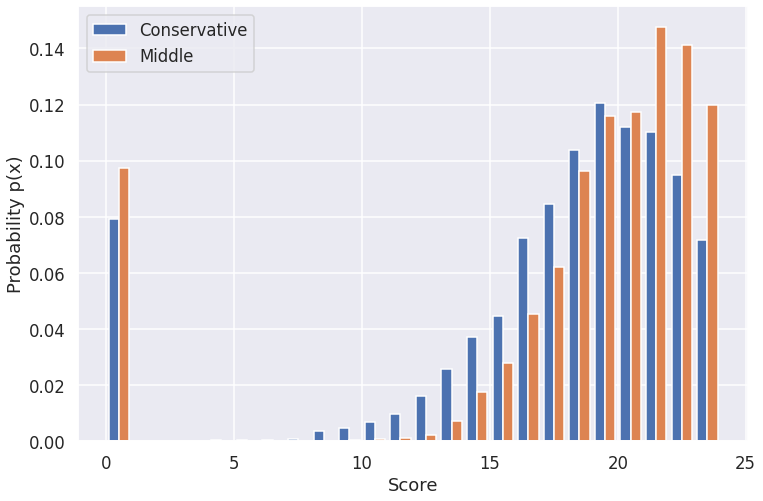

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel("Score")
ax.set_ylabel("Probability p(x)")
ax.hist(samples.values(), bins=range(0, 25), density=True, label=list(samples.keys()))
plt.legend()
plt.show()

Other way, perhaps more intuitive, is to look at the score complementary cumulative distribution, defined as

$$
P(x) = p(X\geq x) = \text{Probability of scoring } x \text{ or more.}
$$

In other words, $P(x)$ gives the tie or win probability against each score.

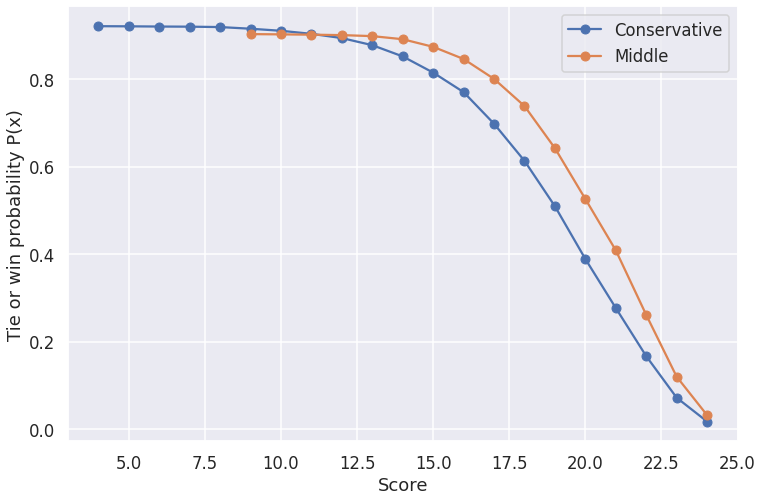

In [11]:
fig, ax = plt.subplots()
for name, sample in samples.items():
    (
        sample.value_counts(normalize=True)
        .sort_index(ascending=False)
        .drop(0)
        .cumsum()
        .plot(marker="o", xlabel="Score", ylabel="Tie or win probability P(x)", label=name, ax=ax)
    )
ax.legend()
plt.show()

### Full game simulation

In [12]:
n_rounds = 10000
n_players = 2
initial_stake = 1000

print("-----------------")
print("Game settings")
print(f"Number of players: {n_players}")
print(f"Number of rounds: {n_rounds}")
print(f"Initial stake: {initial_stake}")
print("-----------------")
print()

Player.reset_counter()
game = Game(n_rounds=n_rounds)
player1 = Player(
    strategy=AlwaysConservativeStrategy(), initial_stake=initial_stake
)
game.add_player(player1)
player2 = Player(
    strategy=AlwaysMiddleStrategy(), initial_stake=initial_stake
)
game.add_player(player2)

# Play game
game.play()

print("-----------------")
print("Game stats")
stats = game.get_game_stats()
display(stats.head(10))
print("-----------------")
print()
print(f"Final relative stakes: {game.relative_stakes}")
print()

print("-----------------")
print("Scores")
scores = game.get_all_scores()
display(scores.head())
print("-----------------")
print()

print("-----------------")
print("Qualification rate per player:")
display((scores > 0).mean())
print("-----------------")
print()

print("-----------------")
print("Win rate per player:")
display(stats["WINNER"].value_counts(normalize=True))
print("-----------------")
print()


-----------------
Game settings
Number of players: 2
Number of rounds: 10000
Initial stake: 1000
-----------------

-----------------
Game stats


,ROUND,POT,WINNER,SCORES
0,0,2,Player2,"[19, 22]"
1,1,2,Player1,"[20, 18]"
2,2,3,Player1,"[17, 0]"
3,3,2,Tie,"[22, 22]"
4,4,4,Player2,"[19, 20]"
5,5,2,Player2,"[21, 24]"
6,6,2,Player2,"[19, 23]"
7,7,2,Player2,"[18, 19]"
8,8,3,Player1,"[20, 0]"
9,9,2,Player1,"[19, 15]"


-----------------

Final relative stakes: [-2083, 2083]

-----------------
Scores


,Player1,Player2
0,19,22
1,20,18
2,17,0
3,22,22
4,19,20


-----------------

-----------------
Qualification rate per player:


Player1    0.9118
Player2    0.9071
dtype: float64

-----------------

-----------------
Win rate per player:


Player2    0.5506
Player1    0.3562
Tie        0.0932
Name: WINNER, dtype: float64

-----------------



In [13]:
nsamples = int(1e4)
samples = {"Middle": {}}

In [14]:
start_dice_cases = [
    (6,), (6, 4), (6, 4, 1), (6, 6), (6, 6, 4),
    (6, 6, 6), (6, 6, 1), (6, 1), (6, 6, 6, 1), (4,)
]
for i, start_dice in enumerate(start_dice_cases):
    print(i, start_dice)
    if start_dice in samples["Middle"]:
        continue
    samples["Middle"][start_dice] = pd.Series(
        MiddleStrategy.sample(nsamples, start_dice=start_dice)
    )

0 (6,)
1 (6, 4)
2 (6, 4, 1)
3 (6, 6)
4 (6, 6, 4)
5 (6, 6, 6)
6 (6, 6, 1)
7 (6, 1)
8 (6, 6, 6, 1)
9 (4,)


In [66]:
df = compute_ccdf_dataframe(samples["Middle"])

fig = px.line(
    df, x="Score", y="Probability", color="Dice selection",
    markers=True, height=500, width=900
)
fig.show()

Roll [6, 6, 4, 3, 3, 3]
Conservative choice: [4]
Middle choice:       [4, 6]


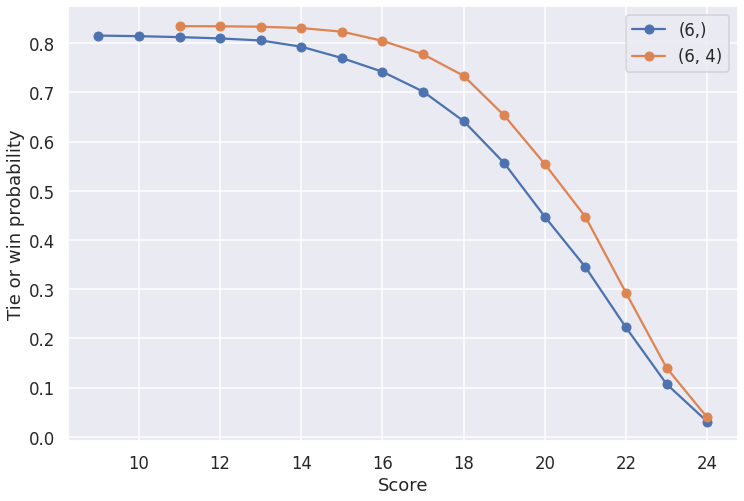

In [16]:
dice = [6, 6, 4, 3, 3, 3]
print("Roll", dice)
print("Conservative choice:", ConservativeStrategy().play([], dice))
print("Middle choice:      ", MiddleStrategy().play([], dice))
_start_dice_cases = [
    (6,), (6, 4)
]

fig, ax = plt.subplots()

for start_dice in _start_dice_cases:
    sample = samples["Middle"][start_dice]
    (
        sample.value_counts(normalize=True)
        .sort_index(ascending=False)
        .drop(0, errors="ignore")
        .cumsum()
        .plot(
            marker="o",
            xlabel="Score",
            ylabel="Tie or win probability",
            label=str(start_dice),
            ax=ax
        )
    )
ax.legend()
plt.show()

Roll [6, 4, 1, 3, 3, 3]
Conservative choice: [4, 1, 6]
Middle choice:       [1, 4, 6]


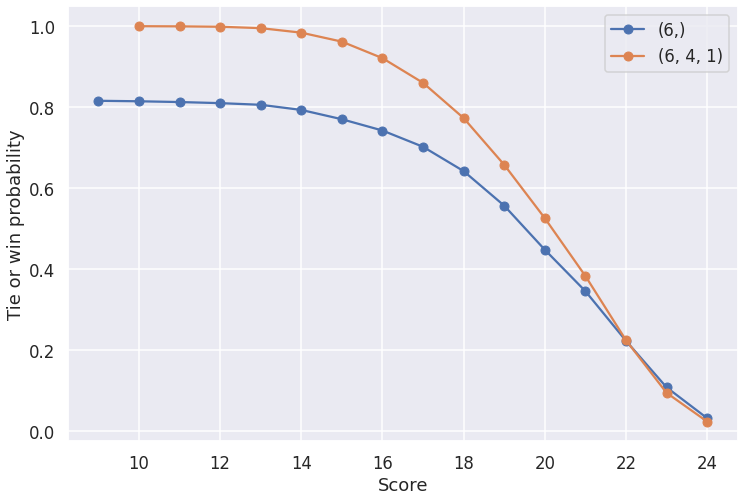

In [17]:
dice = [6, 4, 1, 3, 3, 3]
print("Roll", dice)
print("Conservative choice:", ConservativeStrategy().play([], dice))
print("Middle choice:      ", MiddleStrategy().play([], dice))
_start_dice_cases = [(6,), (6, 4, 1)]

fig, ax = plt.subplots()

for start_dice in _start_dice_cases:
    sample = samples["Middle"][start_dice]
    (
        sample.value_counts(normalize=True)
        .sort_index(ascending=False)
        .drop(0, errors="ignore")
        .cumsum()
        .plot(
            marker="o",
            xlabel="Score",
            ylabel="Tie or win probability",
            label=str(start_dice),
            ax=ax
        )
    )
ax.legend()
plt.show()

Roll [6, 6, 4, 3, 3, 3]
Conservative choice: [4]
Middle choice:       [4, 6]


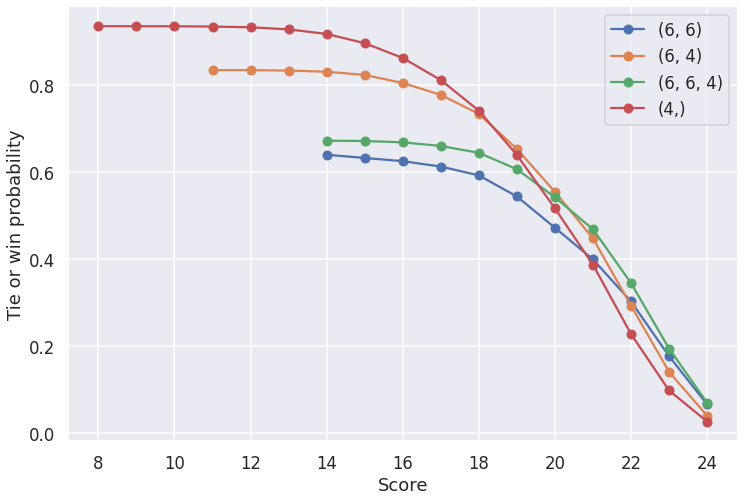

In [18]:
dice = [6, 6, 4, 3, 3, 3]
print("Roll", dice)
print("Conservative choice:", ConservativeStrategy().play([], dice))
print("Middle choice:      ", MiddleStrategy().play([], dice))
_start_dice_cases = [
    #(6,),
    (6, 6), (6, 4), (6, 6, 4), (4,)
]

fig, ax = plt.subplots()

for start_dice in _start_dice_cases:
    sample = samples["Middle"][start_dice]
    (
        sample.value_counts(normalize=True)
        .sort_index(ascending=False)
        .drop(0, errors="ignore")
        .cumsum()
        .plot(
            marker="o",
            xlabel="Score",
            ylabel="Tie or win probability",
            label=str(start_dice),
            ax=ax
        )
    )
ax.legend()
plt.show()

Roll [6, 6, 1, 3, 3, 3]
Conservative choice: [1]
Middle choice:       [1, 6]


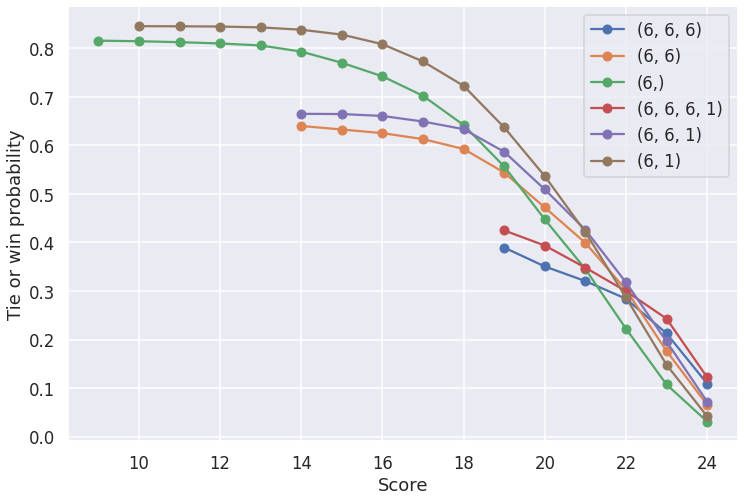

In [19]:
dice = [6, 6, 1, 3, 3, 3]
print("Roll", dice)
print("Conservative choice:", ConservativeStrategy().play([], dice))
print("Middle choice:      ", MiddleStrategy().play([], dice))
_start_dice_cases = [
    #(6,),
    (6, 6, 6), (6, 6), (6,), (6, 6, 6, 1), (6, 6, 1), (6, 1)
]

fig, ax = plt.subplots()

for start_dice in _start_dice_cases:
    sample = samples["Middle"][start_dice]
    (
        sample.value_counts(normalize=True)
        .sort_index(ascending=False)
        .drop(0, errors="ignore")
        .cumsum()
        .plot(
            marker="o",
            xlabel="Score",
            ylabel="Tie or win probability",
            label=str(start_dice),
            ax=ax
        )
    )
ax.legend()
plt.show()